This notebook realises PCA and regression analysis on the following data.
- as data: the features of the speakers (year of birth date, nationality, gender, work occupation)
- as target: the number of occurrences

It tries to answer two questions:
- do the specific combination of features of a speaker have a influence on the number of quotation?
- is the number of occurrences linearly dependent on the features?


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
# from sklearn.preprocessing import OneHotEncoder
# from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import seaborn as sns
%matplotlib inline

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/EPFL/ADA/Cleaned_data/speakers_occurrence_new.parquet'

We load the data that is going to be used for PCA and regression.

In [ ]:
df = pd.read_parquet(DATASET_PATH)
df.head()

,numOccurrences,date_of_birth,transgender female,intersex,genderqueer,cisgender male,cisgender female,genderfluid,transgender person,shemale,transgender male,transmasculine,two-spirit,non-binary,female,male,bigender,Gabon,The Gambia,Guinea,Ivory Coast,Cameroon,Cape Verde,Liberia,Libya,Madagascar,Mauritania,Mauritius,Morocco,Mozambique,Namibia,Niger,Nigeria,Uganda,Rwanda,São Tomé and Príncipe,Senegal,Seychelles,Sierra Leone,Somalia,...,parliamentary group leader,federal judge,forensic psychologist,murderer,khatib,satirist,speculator,associate professor,spy,make-up artist,game tester,nanny,association football player,neurosurgeon,cultural entrepreneur,ice skater,visiting professor,impresario,television presenter,character actor,Liedermacher,discalced carmelite friar,photojournalist,HIV activist,banjoist,child actor,Methodist pastor,educator,basket weaver,professions libérales et assimilés,cadres de la fonction publique,corporate administrative and commercial executive,ingénieurs et cadres techniques d'entreprise,anciens cadres,executive,reggae singer,Storm chaser,KVN actor,bookseller,illuminator
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Q22686,954029,1946.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Q6294,56371,1947.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Q167607,52039,1960.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Q76,47036,1961.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Q355522,31355,1942.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
df = df[(df['date_of_birth']<2017) & (df['date_of_birth']>1900)]

#**1. PCA**

We split the data into the X (features) and y (labels)

In [ ]:
X = df.drop(['numOccurrences'], axis=1)
y = df['numOccurrences']
print(X.shape, y.shape)

(33586, 2082) (33586,)


We create and train the model for PCA. We don't set any number of components as we want to study the global influence of the columns on the number of occurrences.

In [ ]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
pca = PCA()
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)
y = y.reset_index(drop=True)
finalDf = pd.concat([principalDf, y], axis = 1)
print(pca.explained_variance_ratio_)


[1.52258793e-02 1.50072215e-02 1.21147011e-02 ... 4.38724447e-35
 3.81744959e-35 7.70271193e-37]


We plot the ratio of explained variance, i.e the impact of each new column determined by PCA on the number of occurrences.





/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




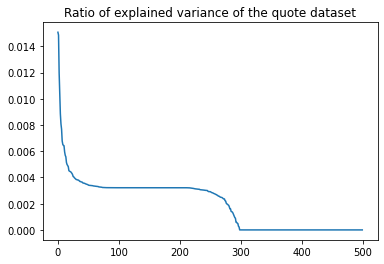

In [ ]:
plt.plot(pca.explained_variance_ratio_[:500])
plt.title("Ratio of explained variance of the quote dataset")

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

trace1 = go.Line(y=pca.explained_variance_ratio_[:300], name='% of explained variance')
trace2 = go.Line(y=np.cumsum(pca.explained_variance_ratio_[:300]), name='cumulative sum of % of explained variance')

fig = go.Figure()
fig = make_subplots(rows=2, cols=1)
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=2, col=1)


fig.update_layout(title_text="PCA Analysis of Speaker-Citation Occurrence",
                  title_font_size=20)
fig.show()
fig.write_html("/content/drive/MyDrive/ADA/html_fig/pca_explained_var.html")

We can see that after 50 columns, the columns don't have much impact on the number of occurrences. It means that the dataset can be resumed by 50 columns
However, we can also see that the first variance is already really low(0.014).

#**2. Linear regression**

We need to remove the outliers since it is pretty unlikely to have a quote from a baby born in 2021 as well as from someone born in year 18 interviewed thanks to a time machine and reported in newspaper.

In [ ]:
df = df[df['numOccurrences']<5000]

We first normalize the column corresponding to the date of birth to be able to able to compare this feature with the other variables and then split the dataset into the feature matrix X and the class vector y.

In [ ]:
X = df.drop(['numOccurrences'], axis=1)
feature_cols = X.columns
y = df.numOccurrences
print(X.shape, y.shape)

(33513, 2082) (33513,)


Text(0.5, 1.0, 'Male and female')

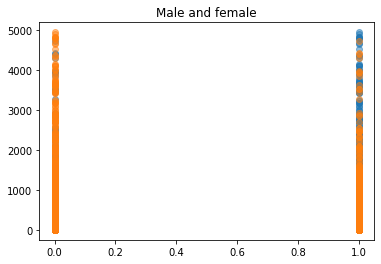

In [ ]:
plt.scatter(X['male'], y, alpha=0.5)
plt.scatter(X['female'], y, alpha=0.5)
plt.title('Male and female')

In [ ]:
# Create the model
lin_reg = LinearRegression()
# Train
lin_reg.fit(X, y)

LinearRegression()

In [ ]:
for f in range(len(feature_cols)):
    print("{0} * {1} + ".format(lin_reg.coef_[f], feature_cols[f]))
print(lin_reg.intercept_)

0.32916035050733944 * date_of_birth + 
-124.9862005745519 * transgender female + 
404.4003838083733 * intersex + 
-143.98104073766012 * genderqueer + 
-60.07224890357976 * cisgender male + 
110.9395615896816 * cisgender female + 
-50.655223058791606 * genderfluid + 
117.06834339338648 * transgender person + 
-171.34396868407583 * shemale + 
-160.36555840195786 * transgender male + 
-57790792057871.54 * transmasculine + 
-50.30973430771108 * two-spirit + 
-130.9707975821264 * non-binary + 
-110.08874085207029 * female + 
-100.08351456451149 * male + 
57790792057702.67 * bigender + 
1.1330915874482912 * Gabon + 
83.28595745518089 * The Gambia + 
-22.905785028140514 * Guinea + 
8.784874351186048 * Ivory Coast + 
-6.76626898887919 * Cameroon + 
-16.772424148761118 * Cape Verde + 
-3.1977444569181515 * Liberia + 
-16.919176674282035 * Libya + 
-16.29751886455169 * Madagascar + 
19.84029896012753 * Mauritania + 
3.8133701054289943 * Mauritius + 
-17.078351965426698 * Morocco + 
154.409313202

We can plot the prediction versus the original values.

In [ ]:
lr = LinearRegression()

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, X, y, cv=10)

# Plot the results
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.scatter(y, predicted, edgecolors=(0, 0, 0))
# ax.plot([min(y), max(y)], [min(y), max(y)], 'r--', lw=4)
# ax.set_xlabel('Original')
# ax.set_ylabel('Predicted')
# plt.show()

In [ ]:
y.head()

id
Q7173106    4939
Q2036942    4906
Q4496       4824
Q1683881    4819
Q324546     4791
Name: numOccurrences, dtype: int64

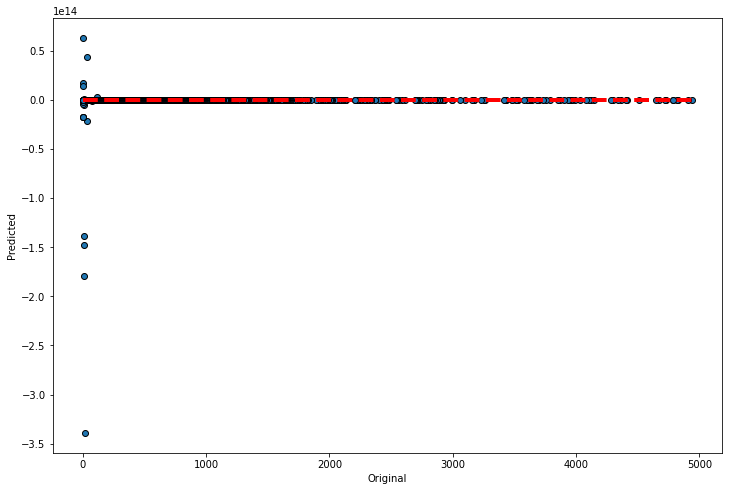

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([min(y), max(y)], [min(y), max(y)], 'r--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
mean_squared_error(y, predicted)

5.850139306171494e+24